In [1]:
# -----------------------------------------------------------
# Ferramenta Graph Walker
#
# (C) 2021 Vivian Poetzscher, Rio de Janeiro, Brazil
# 
# email vivian.yuan@uniriotec.br
# -----------------------------------------------------------

In [2]:
#imports
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from random import randint
from random import sample
from operator import itemgetter, attrgetter
from IPython.display import clear_output
from scipy.stats import bernoulli
from scipy.special import expit
import math as math
from matplotlib.pyplot import figure

In [3]:
#Variáveis de entrada

#Criar malha predefinida (True) ou importar .csv (False)
criarmalha=False

alturay = 7
largurax = 7
ponte=False 

#Inserir DataBase
docimport=r'C:\Users\vivib\OneDrive\Documents\filesgraphwalker\input_river.csv' 
delimiter=','

plot=1
#0 -> simple map
#1 -> presence with color
#2 -> presence with color and numbers
#3 -> path with color
plottime=0.05

tmax=50 #number of maximum steps

#criar sumidouro
sumidouro=False

#Selecionar Sumidouro(s) ex:lista = [('1-1'), ('12-12')]
target = [('6-0')]
#bridge [('2-0'), ('4-0'), ('6-0'), ('9-0')]
#lake [('1-0'), ('12-0'), ('15-8'), ('9-13'), ('3-12'), ('7-0')]
#river [('6-0'), ('0-4'), ('18-0'), ('22-4'), ('19-17'), ('7-17'), ('0-13')]


#Chance de escolher o caminho para o sumidouro
targetchance= 0.7 #Bernoulli

#Numero de objetos no mapa aleatoriamente
nobj = 10

#Definir startpoint de objetos adcionais
usestart= False
start = [('2-2')]
targetstart=[(0)] #index do target^

#utilizar peso(tem mais chance de escolher o caminho com menor peso) baseado no targetchance
useweights=True

#utilizar probabilidade de parar
usestop= True 

#gerar random weights (ira sobrescrever qualquer weight predefinido)
randweight=False
randomseed=9000

weightrange=5 #peso de 1 a 5

In [4]:
# cálculo da probabilidade do objeto parar no vértice em função da quantidade de objs atual no vértice
# n = numero de objetos no vertice
# retorna probabilidade

def prob(n):
    
    # max|probabilidade do objeto parar
    maxprob=0.96 
    minprob=0.02
   
    # 50% de chance
    mid=4
    
    # sigmoide
    result = 1 / (1 + np.exp(-n+mid))

    if(result>maxprob):
        return maxprob
    if(result<minprob):
        return minprob
    else:
        return result

In [5]:
df = pd.read_csv (docimport, delimiter = delimiter)
G = nx.Graph()
seed(randomseed)
xsize=0
ysize=0

def create():
    if(criarmalha):
        nodebefore1=0
        nodebefore2=0

        #Malha
        if not(ponte):
            for a in range(alturay):
                for l in range(largurax):
                    node=str(int(l))+ '-' + str(int(a))
                    G.add_node(node)
                    G.nodes[node]['pos']=(int(l), int(a))
                    if(not (l==0)):
                        beforenode=str(int(l)-1)+'-'+str(int(a))
                        G.add_edge(node, beforenode)
                    if(not(a==0)):
                        beforenode=str(int(l))+'-'+str(int(a)-1)
                        G.add_edge(node, beforenode)

        #Ponte
        if(ponte):
            alt=int(alturay/2)
            lar=int(largurax/2)

            for a in range(alturay):
                if (a==alt):
                    bridgeend1= str(lar)+'-'+str(alt-1)
                    bridgeend2= str(lar)+'-'+str(alt+1)
                    G.add_edge(bridgeend1,bridgeend2)
                else:   
                    for l in range(largurax):
                        node=str(int(l))+ '-' + str(int(a))
                        G.add_node(node)
                        posicao=(l, a)
                        G.nodes[node]['pos']=posicao
                        if not (l==0):
                            beforenode=str(int(l)-1)+'-'+str(int(a))
                            G.add_edge(node, beforenode)
                        if not(a==0):
                            if not(a==alt+1):
                                beforenode=str(int(l))+'-'+str(int(a)-1)
                                G.add_edge(node, beforenode)
                            else:
                                beforenode=str(l)+'-'+ str(int(a)-2)
        cleanweight()
    else:
        global docimport
        global delimiter
        
        df=pd.read_csv (docimport, delimiter=delimiter)
        for index, row in df.iterrows():
            pos1= (row['x1'], row['y1'])
            pos2= (row['x2'], row['y2'])
            edgeweight= row['weight']
            edgeid=row['edge_id']
            
            node1=str(row['x1'])+'-'+ str(row['y1'])
            node2=str(row['x2'])+'-'+ str(row['y2'])
            if not(G.has_node(node1)):
                G.add_node(node1)
                G.nodes[node1]['pos']=pos1   
            if not(G.has_node(node2)):
                G.add_node(node2)
                G.nodes[node2]['pos']=pos2
                    
            G.add_edge(node1, node2, weight=edgeweight)
            

def settargets():
    global target
    
    nx.set_node_attributes(G, 0, "target")
    
    for t in range(len(target)):
        if(G.has_node(target[t])):
            G.nodes[target[t]]["target"]=1
        
def cleanpresence():
    nx.set_node_attributes(G, 0, "pres")


def cleanpath():
    nx.set_edge_attributes(G, 0, "path")

    
def cleanweight():
    nx.set_edge_attributes(G, 1, "weight")
    
def randweight():
    global weightrange
    global randweight
    #1 a 4.6 for visualization purposes (width)
    
    for e in G.edges():
        if(randweight):
            raw=randint(1, weightrange)   
        else:
            raw=G.edges[e]['weight']
            
        scaled= (raw*4.6)/weightrange
        
        G.edges[e]['weight']= scaled

        
def whichtarget():
    global target
    if(len(target)>1):
        t=randint(0, len(target)-1)
        return target[t]
    else:
        return target[0]

def getmaxsize(axis):
    #axis 0=x 1=y
    global xsize
    global ysize
    
    r = sample(list(G.nodes()),2)
    r1= r[0]
    r2= r[1]

    maxi=int(G.nodes[r1]['pos'][axis])
    mini=int(G.nodes[r2]['pos'][axis])
    

    for n in G.nodes():
        if(int(G.nodes[n]['pos'][axis])>maxi):
            maxi= int(G.nodes[n]['pos'][axis])
        if(int(G.nodes[n]['pos'][axis])<mini):
            mini= int(G.nodes[n]['pos'][axis])
    
    if(axis==0): 
        xsize=maxi-mini
    else:
        ysize=maxi-mini

In [6]:
def plotar(tempo, stop):
    global alturay
    global largurax
    global plot
    global target
    global sumidouro
    global useweights
    global criarmalha
    global plottime
    
    clear_output(wait=True)
    pos = nx.get_node_attributes(G, 'pos')
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"]=(9, 6)
    plt.rcParams.update({'font.size': 12})
    title=''
    weights=1
    
    if(useweights):
        edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
        
        
    if not(tempo==-1):
        title +='T= ' + str(tempo)
    
    if not(stop==-1):
        title +=' | N objs reached target: '+str(stop)
    
    ax.set_title(title)
    
    target_nodes = [n for (n,ty) in nx.get_node_attributes(G,'target').items() if ty == 1]
    
    if(plot==1):#pacman style
        edges,pres = zip(*nx.get_node_attributes(G,'pres').items())
        nx.draw(G, pos=pos, node_size=20, ax=ax, width=weights, node_color=pres, edge_color='#EAEAEA' ,cmap=plt.cm.Reds)
        if(sumidouro):
            nx.draw_networkx_nodes(G, pos, nodelist=target_nodes, node_color='green', node_shape='s', node_size=25)
    
    elif (plot==2):#pacman with numbers style
        edges,pres = zip(*nx.get_node_attributes(G,'pres').items())
        
        labels = nx.get_node_attributes(G, 'pres')
        
        pos_higher = {}
        
        y_off = 2*ysize/100
        x_off= 2*xsize/100
        for k, v in pos.items():
            pos_higher[k] = (v[0]+x_off, v[1]+y_off)
        
        nx.draw_networkx_labels(G, pos=pos_higher, labels=labels, font_size=8)
        nx.draw(G, pos=pos, node_size=20, ax=ax, width=weights, edge_color='#EAEAEA', node_color=pres , cmap=plt.cm.Reds )
        
        if(sumidouro):
            nx.draw_networkx_nodes(G, pos, nodelist=target_nodes, node_color='green', node_shape='s', node_size=25)

    elif (plot==3):#path 
        edges,paths = zip(*nx.get_edge_attributes(G,'path').items())
        nx.draw(G, pos=pos, node_size=20, node_color='#29a3a3', ax=ax, width=weights, edge_color=paths , edge_cmap=plt.cm.Oranges)  # draw nodes and edges
        if(sumidouro):
            nx.draw_networkx_nodes(G, pos, nodelist=target_nodes, node_color='Green', node_shape='s', node_size=25)
    
    elif (plot==0):
        title=''
        ax.set_title(title)
       
        nx.draw(G, pos=pos, node_size=20, ax=ax, width=weights, node_color='#29a3a3', edge_color='#EAEAEA')  # draw nodes and edges
        

 
        
    plt.axis("on")
    if (criarmalha):
        plt.yticks(np.arange(0, alturay, 1))
        plt.xticks(np.arange(0, largurax, 1))
   

    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    
    plt.pause(plottime)
    

    plt.show()

In [7]:
def randwalk (nodeatual):
    edges=list(G.edges(nodeatual))   
    nextedge = randint(0, len(edges)-1)
    
    return getnodefromedge(nodeatual, edges[nextedge])


def randwalkto (nodeatual, destination):
    global target

    edges=list(G.edges(nodeatual))

    nextnode = getnextinpath(nodeatual, destination)
   

    if not(nodeatual==nextnode):
        nextedge = getedgefromnode(nodeatual, nextnode)
        edges.remove(nextedge)
    
    gototarget=calcchance()
    
    if(gototarget or len(edges)==0):
        return nextnode
    
    else:
        n = edges[randint(0, len(edges)-1)]
        return getnodefromedge(nodeatual, n)
        

def getnextinpath (source, destination):
    global useweights
    
    if(useweights):
        n=nx.dijkstra_path(G, source, destination, weight='weight')
    else:
        n=nx.bidirectional_shortest_path(G, source, destination)
    
    if(len(n)>1):
        return (n[1])
    else:
        return source #node
    
    
def getnodefromedge(nodeatual, nextedge):
    if(nextedge[0]==nodeatual):
        return nextedge[1]
    else:
        return nextedge[0]

def getedgefromnode(nodeatual, nextnode):
    return (nodeatual, nextnode)
    
    
def calcchance():
    global targetchance
    
    return bernoulli.rvs(size=1,p=targetchance)
    
    
def addpresence(node, add):
    n=G.nodes[node]['pres']
    n+=int(add)
    if(n<0):
        n=0
    G.nodes[node]['pres']=n
    

def addpath(edge):
    G.edges[edge]['path'] += 1


def attallpaths (total):
    for n in G.edges():
        if (G.edges[n]['path']>0):
            ptemp = G.edges[n]['path']
            G.edges[n]['path']=ptemp/total

def countdestination(destination):
    global target
    count=list()
    for i in target:
        count.append(0)
    
    for i in destination:
        for t in range (len(target)):
            if(i==target[t]):
                count[t]+=1
                break
    print("\nQtd de objs focando cada destino:")
    res = dict(zip(target, count))
    print(res)



In [8]:
def simulate():
    global tmax
    global nobj
    global sumidouro
    global target
    global plot
    global useweights
    global usestart
    global start
    global targetstart
    global usestop
    
    if not(usestart):
        cleanpresence()
    
    if (useweights): randweight()
    
    if not(plot==0):
        totmoves=0 #total moves so far

        objs = list()
        stopped = list()
        stop = 0
        destination = list()
       
            
        
        nodes_list = list(G.nodes())
        lennodes=len(nodes_list)
        
        for i in range(nobj):#inicialize
            randomNodeIndex = randint(0, lennodes-1)
            objs.append(nodes_list[randomNodeIndex])
            stopped.append(0)
            destination.append(whichtarget())

        if(usestart):
            nobj+=len(start)
            for i in range(len(start)):
                objs.append(start[i])
                stopped.append(0)
                destination.append(target[targetstart[i]])
            
        objsnext=objs.copy()    
        
        for t in range(tmax):
            temp=objsnext.copy()

            for n in range (nobj):
                if(stopped[n]==0):
                    totmoves+=1
                    addpresence(objsnext[n], 1)

                    if not(objsnext[n]==objs[n]):
                        addpath(getedgefromnode(objsnext[n], objs[n]))

                    if(sumidouro):
                        if(objs[n]==destination[n]):
                            stop+=1
                            stopped[n]=1
                            addpresence(objs[n], -1)
                            
                        if(usestop):
                            ncarros=G.nodes[objsnext[n]]['pres']
                            p= prob(ncarros)
                            s= bernoulli.rvs(size=1,p=p)
                            if not(s):
                                objsnext[n]=randwalkto(objsnext[n], destination[n])
                            
                        else:
                            objsnext[n]=randwalkto(objsnext[n], destination[n])


                    else:
                        if(usestop):
                            ncarros=G.nodes[objsnext[n]]['pres']
                            p= prob(ncarros)
                            s= bernoulli.rvs(size=1, p=p)
                            if not(s):
                                objsnext[n]=randwalk(objsnext[n])

            objs=temp.copy()
            if(sumidouro):

                plotar(t, stop)

            else:
                plotar(t, -1)

            cleanpresence()
            if (stop==nobj):
                plotar(t, stop)
                print('Finalizado em '+str(t)+' passos.')
                
                break
        if(sumidouro):
            countdestination(destination)
    else:
        plotar(0, -1)
        plotar(0, -1)

    

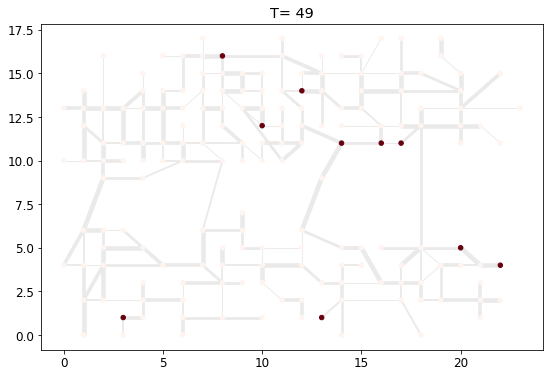

In [9]:
def main():
    
    create()
    cleanpresence()
    cleanpath()
    settargets()
    getmaxsize(0)
    getmaxsize(1)
    
    simulate()
    

if __name__ == "__main__":
    main()